<a href="https://www.kaggle.com/code/iqmansingh/machine-failures-baseline?scriptVersionId=133553539" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark")
print("Setup Complete")

/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv
/kaggle/input/machine-failure-predictions/machine failure.csv
Setup Complete


In [2]:
train_path = "../input/playground-series-s3e17/train.csv"
orig_path = "../input/machine-failure-predictions/machine failure.csv"
test_path = "../input/playground-series-s3e17/test.csv"

train_data = pd.read_csv(train_path,index_col="id")
orig_data = pd.read_csv(orig_path,index_col="UDI")
test_data = pd.read_csv(test_path,index_col="id")

train_data = train_data.append(orig_data)
train_data.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [3]:
print(train_data.info(),test_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146429 entries, 0 to 10000
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Product ID               146429 non-null  object 
 1   Type                     146429 non-null  object 
 2   Air temperature [K]      146429 non-null  float64
 3   Process temperature [K]  146429 non-null  float64
 4   Rotational speed [rpm]   146429 non-null  int64  
 5   Torque [Nm]              146429 non-null  float64
 6   Tool wear [min]          146429 non-null  int64  
 7   Machine failure          146429 non-null  int64  
 8   TWF                      146429 non-null  int64  
 9   HDF                      146429 non-null  int64  
 10  PWF                      146429 non-null  int64  
 11  OSF                      146429 non-null  int64  
 12  RNF                      146429 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 15.6+ MB
<c

In [4]:
train_dup = train_data[train_data.duplicated()]
print(train_dup.shape)
train_data.drop_duplicates(inplace=True)

(1134, 13)


In [5]:
train_data.drop(["Product ID"],inplace=True,axis=1)
test_data.drop(["Product ID"],inplace=True,axis=1)

In [6]:
test_data.columns

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF',
       'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

# RENAMING COLUMNS

In [7]:
train_data.columns = ['Type', 'Air_Temp', 'Process_Temp', 'Rot_Speed', 'Torque',
       'Tool_Wear', 'Machine Failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
test_data.columns = ['Type', 'Air_Temp', 'Process_Temp', 'Rot_Speed', 'Torque',
       'Tool_Wear', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

In [8]:
objectDTypeCols = ['Type']


dummy = []
for i in objectDTypeCols:
    dummy.append(pd.get_dummies(train_data[i]))
dummy_df = pd.concat(dummy, axis=1)
train_data = pd.concat((train_data,dummy_df), axis=1)

dummy = []
for i in objectDTypeCols:
    dummy.append(pd.get_dummies(test_data[i]))
dummy_df = pd.concat(dummy, axis=1)
test_data = pd.concat((test_data,dummy_df), axis=1)

train_data.drop(objectDTypeCols,inplace=True,axis=1)
test_data.drop(objectDTypeCols,inplace=True,axis=1)

test_data.head()

,Air_Temp,Process_Temp,Rot_Speed,Torque,Tool_Wear,TWF,HDF,PWF,OSF,RNF,H,L,M
id,,,,,,,,,,,,,
136429,302.3,311.5,1499,38.0,60,0,0,0,0,0,0,1,0
136430,301.7,311.0,1713,28.8,17,0,0,0,0,0,0,1,0
136431,301.3,310.4,1525,37.7,96,0,0,0,0,0,0,1,0
136432,300.1,309.6,1479,47.6,5,0,0,0,0,0,0,0,1
136433,303.4,312.3,1515,41.3,114,0,0,0,0,0,0,0,1


# PLOTTING CORRELATION

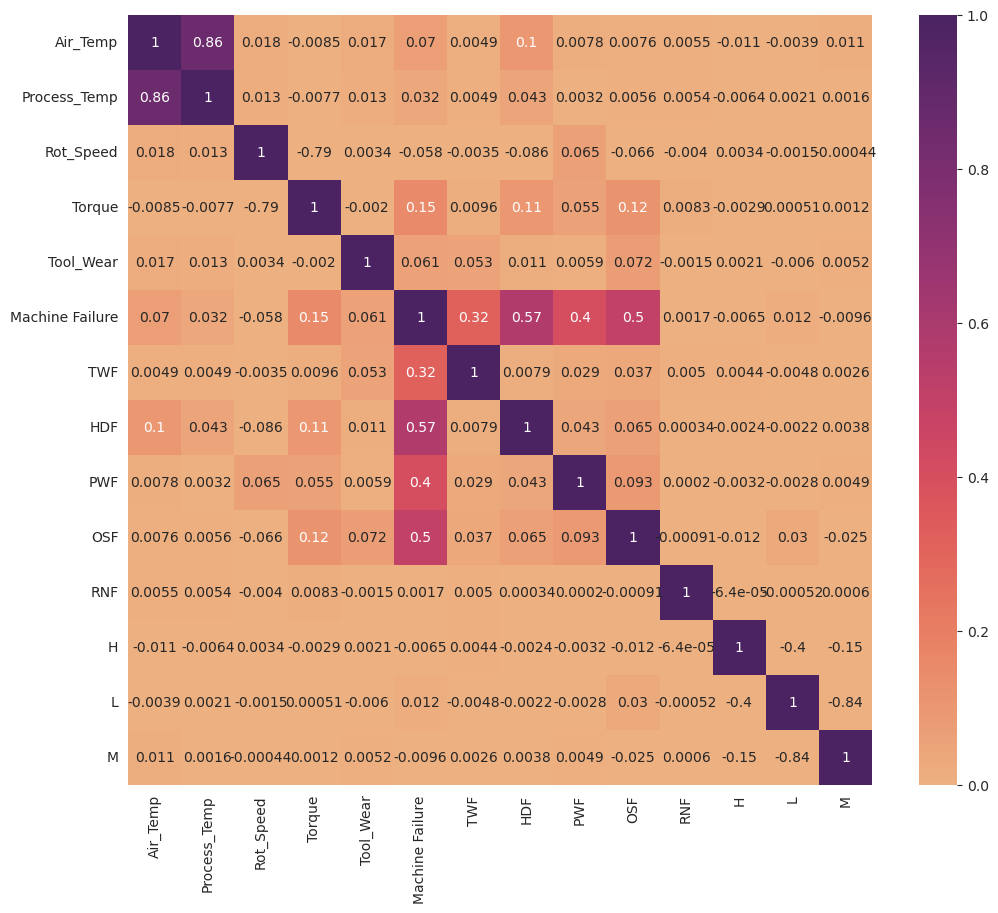

In [9]:
features = [i for i in train_data.columns]
corr = train_data[features].corr(numeric_only=False)
plt.figure(figsize = (12,10))
sns.heatmap(corr, cmap = 'flare', annot = True,vmin=0);

# **Baseline** 
## Models:
1. RandomForestClassifier
1. GradientBoostingClassifier
1. XGBClassifier
1. LGBMClassifier
1. HistGradientBoostingClassifier
1. CatBoostClassifier
1. VotingClassifier

In [10]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [11]:
cols = [i for i in train_data.columns if i!="Machine Failure"]
X_train, X_test, y_train, y_test = train_test_split(train_data[cols], train_data["Machine Failure"], test_size=0.3,random_state=100)
seed = np.random.seed(0)

In [12]:
train_x = train_data[cols]  # Full training data
train_y = train_data["Machine Failure"] # Full training data

# train_x = X_train
# train_y = y_train

In [13]:
rfmodel = RandomForestClassifier(random_state=seed)
rfmodel.fit(train_x,train_y)
print("Accuracy of RF:",accuracy_score(y_test, rfmodel.predict(X_test))*100)

Accuracy of RF: 99.96788180504255


In [14]:
gbmodel = GradientBoostingClassifier(random_state=seed,warm_start=True)
gbmodel.fit(train_x,train_y)
print("Accuracy of GB:",accuracy_score(y_test, gbmodel.predict(X_test))*100)

Accuracy of GB: 99.66505310972951


In [15]:
hgbmodel = HistGradientBoostingClassifier(random_state=seed,warm_start=True)
hgbmodel.fit(train_x,train_y)
print("Accuracy of HGB:",accuracy_score(y_test, hgbmodel.predict(X_test))*100)

Accuracy of HGB: 99.66964142329486


In [16]:
xgbmodel = XGBClassifier(random_state=seed)
xgbmodel.fit(train_x,train_y)
print("Accuracy of XGB:",accuracy_score(y_test, xgbmodel.predict(X_test))*100)

Accuracy of XGB: 99.72928949964441


In [17]:
lgbmmodel = LGBMClassifier(random_state=seed)
lgbmmodel.fit(train_x,train_y)
print("Accuracy of LGBM:",accuracy_score(y_test, lgbmmodel.predict(X_test))*100)

Accuracy of LGBM: 99.68111220720824


In [18]:
catmodel = CatBoostClassifier(random_state=seed,verbose=False)
catmodel.fit(train_x,train_y)
print("Accuracy of CAT:",accuracy_score(y_test, catmodel.predict(X_test))*100)

Accuracy of CAT: 99.75452522425383


In [19]:
vcmodel = VotingClassifier([("rf",rfmodel),("cat",catmodel)])
vcmodel.fit(train_x,train_y)
print("Accuracy of VC:",accuracy_score(y_test, vcmodel.predict(X_test))*100)

Accuracy of VC: 99.75911353781918


In [20]:
predictions = vcmodel.predict(test_data)

In [21]:
data = pd.read_csv(test_path)

colsToDrop = [i for i in data.columns if i !="id"]
submission = data.drop(colsToDrop,axis=1)
submission["Machine failure"] = predictions

In [22]:
submission.head()

,id,Machine failure
0,136429,0
1,136430,0
2,136431,0
3,136432,0
4,136433,0


In [23]:
submission.to_csv("submission.csv",index=False,header=True)